Проект нашей команды на второй тур отборочного этапа Сириус.ИИ.

Мы разработали сервис для оценки цены недвижимости. 
Для обучения модели нам необходимы качественные и обработанные данные.

Качество данных зависит не от нас (Верим Яндексу и ВШЭ ФКН), поэтому займёся предобработкой.

## Исследование данных.

В рамках дополнительного задания нам было предложено провести исследование данных с информацией о сделках с недвижимость в Москве за определённый период времени.

Анализ будем производить с помощью средств библиотек:
- pandas - управление данными
- seaborn - анализ графиков

In [1]:
# подключим необходимые библиотеки
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Простые функции для более выраженного кода.

def object_to_float(df, column):
    df[column] = df[column].astype(float)


def float_to_int(df, column):
    df[column] = df[column].astype(int)

## Шаги исследования.
- Обработка отсутствующих значени.
    
    Посмотрите на отсутствующие значения и подума те, стоит ли исключать строки с ними из датасета. Если нет, то нужно придумать решение, которое позволит обрабатывать отсутствующие значения в каждом из поле.
- Обработка лишних значений. 

    Выясните, какие значения можно убрать из датасета без потери информации. Ориентируйтесь на корреляцию между полями.

- Выявление аномали.

    Посмотрите на распределения значени , есть ли там выбросы и аномалии? Если да, то с чем они связаны и как их обработать?

- Сбалансированность.

    Проверьте, сбалансированы ли данные. Подума те, по каким признакам смотреть баланс.

- Базовы отбор признаков.

    Выясните, какие признаки влияют на целевую переменную – цену, а какие нет. Это можно сделать с помощью визуализаци . Можно изучать как отдельные признаки, так и их комбинации.

- Статистики.

    Посчита те основные статистики на основе данных, имеет смысл сделать это по годам. Сравните с современными данными по Москве (обязательно укажите, откуда брали современные данные).

### Обработка train.csv

In [3]:
train = pd.read_csv("data/train.csv", skipinitialspace=True, sep=',', decimal=',')

train.shape

(30471, 292)

In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


Заметим, что у нас около 300 признаков, на которых будет обучаться модель.
Некоторые из них имеют прямое влияние на ценообразование, некоторые другие могут совершенно не влиять.

Для более качественного анализа исключим сильно скоррелированные данные.

#### Обработка отсутствующих значений.

Заметим, что используемая нами модель не предназначена для обучения на данных с отсутствующими значениями. 

Поэтому нам придётся их обработать. Есть три пути решения данной проблемы:
1) Удаление пустых значений (записей, колонок) (drop)

    Плюсы:
    - Простое решение.
    
    Минусы:
    - Потеря данных. Количество данных, на которой будет обучатся модель, может сильно уменьшится. Поэтому будем выбирать между удалением строк(теряем данные) и столбцов(теряем характеристику).
2) Заполнение некоторым другим значением (медиана, мода, ср.ариф)

    Плюсы:
    - Не теряем данные.

    Минусы:
    - Заполнение данных может сильно повлиять на распределение и "запутать" модель.
    - Задача заполнения значений может оказаться трудной.

In [5]:
# слишком много пропусков, нужен для идентификации.
train = train.drop(columns=['life_sq', 'id'])

Подумав некоторое время, мы решили заполнить значения в пропусках медианным значениями, так как на наш взгяд, это самое хорошее решение.

##### Категориальные признаки.
Модель которая будет использована в дальнейшем не умеет обрабатывать категориальные признаки.
Поэтому разделим данные на категориальные и числовые, отдельно обработаем числовые и категориальные.

In [6]:
categorial_columns = train.dtypes[train.dtypes == 'object'].index.to_list()
numeric_columns = train.dtypes[train.dtypes != 'object'].index.to_list()

print(categorial_columns)
print(numeric_columns)

['timestamp', 'product_type', 'sub_area', 'area_m', 'green_zone_part', 'indust_part', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'railroad_station_avto_km', 'railroad_station_avto_min', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'water_1line', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'big_road1_1line', 'big_road2_km', 'railroad_km', 'railroad_1line', 'zd_vokzaly_avto_km', 'bus_terminal_avto_km', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km'

Проанализировав имеющиеся категориальные признаки, мы заметили в них числовые характеристики.
С помощью следующего кода перведём их в числовой формат.

In [7]:
train['culture_objects_top_25'] = train['culture_objects_top_25'] == 'yes'
train['water_1line'] = train['water_1line'] == 'yes'

new_categorial_columns = []
for category in categorial_columns:
    if 'raion' in category:
        train[category] = train[category] == 'yes'
        numeric_columns.append(category)
    elif 'km' in category or '00' in category:
        train[category] = train[category].astype(float)
        numeric_columns.append(category)
    else:
        new_categorial_columns.append(category)
categorial_columns = new_categorial_columns

print(categorial_columns)
print(numeric_columns)

['timestamp', 'product_type', 'sub_area', 'area_m', 'green_zone_part', 'indust_part', 'culture_objects_top_25', 'metro_min_avto', 'metro_min_walk', 'railroad_station_walk_min', 'railroad_station_avto_min', 'public_transport_station_min_walk', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology']
['full_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'raion_popul', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_femal

In [8]:
# Заполняем пропуски медианным значением
for column in numeric_columns:
    if train[column].isnull().sum() != 0:
        train[column] = train[column].astype(float)
        train[column] = train[column].fillna(train[column].median())


#### Обработка лишних значений.

Выясните, какие значения можно убрать из датасета без потери информации. Ориентируйтесь на корреляцию между полями.

Сильно скоррелированные параметры взаимосвязаны между собой. Так, что они не дают новой информации, поэтому их можно удалить, не боясь потерять данные.

In [9]:
numeric_train = train[numeric_columns]

correlation_matrix = numeric_train.corr()

correlated_features = set()
for column in range(len(correlation_matrix.columns)):
    for j in range(column):
        if abs(correlation_matrix.iloc[column, j]) > 0.5:
            colname = correlation_matrix.columns[column]
            correlated_features.add(colname)


# Удаляем скоррелированные признаки из DataFrame
train = train.drop(correlated_features, axis=1)
# переприсваиваем числовые колонки
numeric_columns = train.dtypes[train.dtypes != 'object'].index.to_list()

In [10]:
numeric_columns

['full_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'raion_popul',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'university_top_20_raion',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'build_count_block',
 'build_count_foam',
 'ID_metro',
 'metro_km_avto',
 'green_zone_km',
 'industrial_km',
 'cemetery_km',
 'ID_railroad_station_walk',
 'water_km',
 'water_1line',
 'big_road1_km',
 'ID_big_road1',
 'ID_big_road2',
 'ID_railroad_terminal',
 'ID_bus_terminal',
 'prom_part_500',
 'cafe_sum_500_min_price_avg',
 'mosque_count_500',
 'leisure_count_500',
 'market_count_500',
 'price_doc']

In [11]:
train.shape

(30471, 56)

#### Выявление аномалий.

Проанализируем распределение данных. 

Если в них будут выбросы то это может негативно сказаться на итоговом качестве модели.

Именно поэтому важно их удалять.

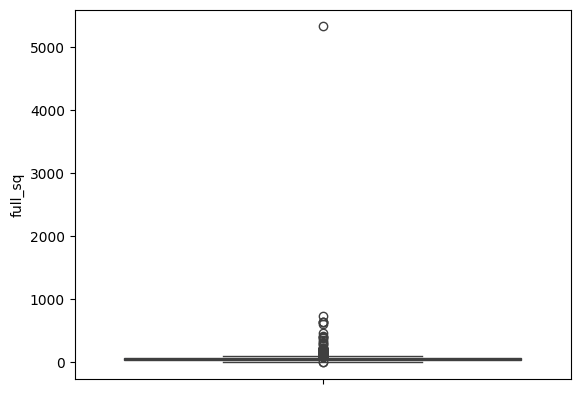

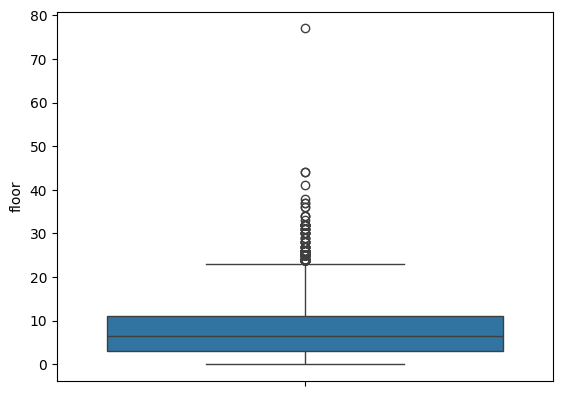

In [12]:
# Визуализация выбросов при помощи ящиков с усами. Для ускорения посмотрим 2 графика.
for column in ['full_sq', 'floor']:
    sns.boxplot(train[column])
    plt.show()
    

Видно, что есть некоторое количество выбросов, которые мы сейчас удалим.

In [13]:
train = train[train['state'] < 10]
train = train[(train['build_year'] > 1850) & (train['build_year'] <= 2015)]

#обработка выбросов при помощи z-показателя заменой на меданное значение
for column in numeric_columns:
    z_scores = (train[column] - train[column].mean()) / train[column].std()

    # Задаем порог для определения выбросов (обычно 3 или -3 для 99.7% данных)
    threshold = 3

    # Фильтрация данных для нахождения выбросов
    outliers = train[abs(z_scores) > threshold]

    # Замена выбросов на медианное значение
    median = train[column].median()
    train.loc[abs(z_scores) > threshold, column] = median

/tmp/ipykernel_37079/452840160.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train.loc[abs(z_scores) > threshold, column] = median
/tmp/ipykernel_37079/452840160.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train.loc[abs(z_scores) > threshold, column] = median
/tmp/ipykernel_37079/452840160.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train.loc[abs(z_scores) > threshold, column] = median
/tmp/ipykernel_37079/452840160.py:16: FutureWarning: Setti

#### Базовый отбор признаков.

Оставим только те признаки, которые влияют на целевую переменную – цену. 

Будем это изучать благодаря анализу зависимостей между ценой и другими характеристиками.

In [14]:
len(numeric_columns)

42